### 밑바닥부터 만들어 보는 딥러닝과 이어지는 부분때문에 이어서 작성

In [1]:
import numpy as np
from numpy import ndarray
from typing import *

In [2]:
def assert_same_shape(array: ndarray,
                      array_grad: ndarray):
  assert array.shape == array_grad.shape, \
  f"""
  두 ndarray의 모양이 같아야 하는데,
  첫 번째 ndarray의 모양은 {tuple(array_grad.shape)}이고,
  두 번째 ndarray의 모양은 {typle(array.shape)}이다.
  """
  return None

#### 신경망 구성 요소: 연산

Operation 클래스

In [3]:
class Operation(object):
  """
  신경망 모델의 연산 역할을 하는 기반 클래스
  """
  def __init__(self):
    pass

  def forward(self, input_: ndarray):
    """
    인스턴스 변수 self._input에 입력값을 저장한 다음 self._output() 함수를 호출한다.
    """
    self.input_ = input_
    self.output = self._output()
    return self.output

  def backward(self, output_grad: ndarray) -> ndarray:
    """
    self._input_grad() 함수를 호출한다. 이때 모양이 일치하는지 먼저 확인한다.
    """
    assert_same_shape(self.output, output_grad)
    self.input_grad = self._input_grad(output_grad)

    assert_same_shape(self.input_, self.input_grad)
    return self.input_grad

  def _output(self) -> ndarray:
    """
    Operation을 구현한 모든 구상 클래서는 _output 메서드를 구현해야 한다.
    """
    raise NotImplementedError()

  def _input_grad(self, output_grad: ndarray) -> ndarray:
    """
    Operation을 구현한 모든 구상 클래스는 _input_grad 메서드를 구현해야 한다.
    """
    raise NotImplementedError()

PraramOperation 클래스

In [4]:
class ParamOperation(Operation):
  """
  파라미터를 갖는 연산
  """

  def __init__(self, param: ndarray) -> ndarray:
    """
    생성자 메서트
    """
    super().__init__()
    self.param = param

  def backward(self, output_grad: ndarray) -> ndarray:
    """
    self._input_grad, self._param_grad를 호출한다.
    이때 ndarray 객체의 모양이 일치하는지 확인한다.
    """
    
    assert_same_shape(self.output, output_grad)

    self.input_grad = self._input_grad(output_grad)
    self.param_grad = self._param_grad(output_grad)

    assert_same_shape(self.input_, self.input_grad)
    assert_same_shape(self.param, self.param_grad)

    return self.input_grad

  def _param_grad(self, output_grad: ndarray) -> ndarray:
    """
    ParamOperation을 구현한 모든 구상 클래스는 _param_grad 메서드를 구현해야 한다.
    """
    raise NotImplementedError()

#### 신경망의 구성 요소: 층

Operaion의 구상 클래스

WeightMulitiply 클래스( 파라미터 행렬과 입력 행렬의 행렬곱 연산)

In [5]:
class WeightMultiply(ParamOperation):
  """
  신경망의 가중치 행렬곱 연산
  """

  def __init__(self, W: ndarray):
    """
    self.param = W로 초기화
    """
    super().__init__(W)

  def _output(self) -> ndarray:
    """
    출력값 계산
    """
    return np.dot(self.input_, self.param)

  def _input_grad(self, output_grad: ndarray) -> ndarray:
    """
    입력에 대한 기울기 계산
    """
    return np.dot(output_grad, np.transpose(self.param, (1, 0)))

  def _param_grad(self, output_grad: ndarray) -> ndarray:
    """
    파라미터에 대한 기울기 계산
    """
    return np.dot(np.transpose(self.input_, (1, 0)), output_grad)

BiadAdd 클래스(편향 향을 더하는 덧셈 연산)

In [6]:
class BiasAdd(ParamOperation):
  """
  편향을 더하는 연산
  """

  def __init__(self, B: ndarray):
    """
    self.param = B로 초기화한다.
    초기화 전에 행렬의 모양을 확인한다.
    """
    assert B.shape[0] == 1

    super().__init__(B)

  def _output(self) -> ndarray:
    """
    출력값 계산
    """
    return self.input_ + self.param

  def _input_grad(self, output_grad: ndarray) -> ndarray:
    """
    입력에 대한 기울기 계산
    """
    return np.ones_like(self.input_) * output_grad

  def _param_grad(self, output_grad: ndarray) -> ndarray:
    """
    파라미터에 대한 기울기 계산
    """
    param_grad = np.ones_like(self.param) * output_grad
    return np.sum(param_grad, axis = 0).reshape(1, param_grad.shape[1])

Sigmoid 클래스(sigmoid 활성화 함수)

In [7]:
class Sigmoid(Operation):
  """
  Sigmoid 활성화 함수
  """

  def __init__(self) -> None:
    """ Pass"""
    super().__init__()

  def _output(self) -> ndarray:
    """
    출력값 계산
    """
    return 1.0 / (1.0 + np.exp(-1.0 * self.input_))

  def _input_grad(self, output_grad: ndarray) -> ndarray:
    """
    입력에 대한 기울기 계산
    """
    sigmoid_backward = self.output * (1.0 - self.output)
    input_grad = sigmoid_backward * output_grad
    return input_grad

Linear 클래스

In [8]:
class Linear(Operation):
  """
  항등 활성화 함수
  """
  def __init__(self) -> None:
    '기반 클래스의 생성자 메서드 실행'
    super().__init__()

  def _output(self) -> ndarray:
    '입력을 그대로 출력'
    return self.input_
  
  def _input_grad(self, output_grad: ndarray) -> ndarray:
    '그대로 출력'
    return output_grad

#### Layer 클래스 설계

- forward와 backward, 이 2개의 메서드는 층에 포함된 일련의 Operation 클래스 객체에 입력값을 순서대로 통과시키는 역할을 한다. 이 과정은 지금까지 우리가 다이어그램을 그려보며 해온 것과 완전히 같다. 이 부분이 실질적으로 Layer 객체가 하는 일이고, 나머지 코드는 코드를 감싸는 래퍼(wrapper) 역할이나 정보를 저장하는 역할을 맞는다.
  - _setup_layer 메서드를 통해 정확한 순서대로 Operation 클래스 객체의 연속을 정의하고 각 Operation 객체의 파라미터를 저장해서 초기화한다.
  - forward 메서드는 self.input_과 self.output에 각각 값을 저장한다.
  - backward 메더스는 역방향 계산을 수행하기 전, 행렬의 모양을 먼저 검사한다.
- 마지막으로 _param._param_grads 메서드는 층에 포함된 ParamOperation 클래스 객체에서 파라미터와 파라미터에 대한 기울기의 값을 꺼낸다.

In [9]:
class Layer(object):
  """
  신경망 모델의 층 역할을 하는 클래스
  """

  def __init__(self, neurons: int):
    """
    뉴런의 개수는 층의 너비에 해당한다.
    """
    self.neurons = neurons
    self.first = True
    self.params: List[ndarray] = []
    self.param_grads: List[ndarray] = []
    self.operations: List[Operation] = []

  def _setup_layer(self, num_in: int) -> None:
    """
    Layer를 구현하는 구상 클래스는 _setup_layer 메서드를 구현해야 한다.
    """
    raise NotImplementedError()

  def forward(self, input_: ndarray) -> ndarray:
    """
    입력값을 각 연산에 순서대로 통과시켜 순방향 계산을 수행한다.
    """
    if self.first:
      self._setup_layer(input_)
      self.first = False

    self.input_ = input_

    for operation in self.operations:
      input_ = operation.forward(input_)

    self.output = input_

    return self.output

  def backward(self, output_grad: ndarray) -> ndarray:
    """
    output_grad를 각 연산에 역순으로 통과시켜 역방향 계산을 수행한다.
    계산하기 전, 행렬의 모양을 검사한다.
    """

    assert_same_shape(self.output, output_grad)

    for operation in reversed(self.operations):
      output_grad = operation.backward(output_grad)

    input_grad = output_grad

    self._param_grads()

    return input_grad

  def _param_grads(self) -> ndarray:
    """
    각 Operation 객체에서 _param_grad 값을 꺼낸다.
    """

    self.param_grads = []
    for operation in self.operations:
      if issubclass(operation.__class__, ParamOperation):      # 상속관계여부 확인 issubclass(자식 클래스, 부모 클래스)
        self.param_grads.append(operation.param_grad)

  def _params(self) -> ndarray:
    """
    각 Operation 객체에서 _params값을 꺼낸다.
    """

    self.params = []
    for operation in self.operations:
      if issubclass(operation.__class__, ParamOperation):
        self.params.append((operation.param))

#### 밀집층 구현하기

In [10]:
class Dense(Layer):
  """
  Layer 클래스를 구현한 전결합층
  """
  def __init__(self,
               neurons: int,
               activation: Operation = Sigmoid()) -> None:
    """
    초기화 시 활성화 함수를 결정해야 함
    """
    super().__init__(neurons)
    self.activation = activation

  def _setup_layer(self, input_: ndarray) -> None:
    """
    전결합층의 연산을 정의
    """
    if self.seed:
      np.random.seed(self.seed)
    
    self.params = []

    # 가중치
    self.params.append(np.random.randn(input_.shape[1], self.neurons))

    # 편향
    self.params.append(np.random.randn(1, self.neurons))

    self.operations = [WeightMultiply(self.params[0]),
                       BiasAdd(self.params[1]),
                       self.activation]

    return None

## NeuralNetwork 클래스와 그 외 클래스
- 데이터로부터 학습하는 클래스

1. 신경망은 X를 입력받아 각 Layer(여러개의 Operation을 묶은 편리한 래퍼)를 순섣로 통과시킨다. 신경망 끝에서 출력된 값이 예측값 prediction이 된다.
2. prediction을 y와 비교하여 손실을 계산한 다음, 이 손실로 마지막 층(prediction을 출력한 층)의 각 요소에 대한 '손실의 기울기'를 계산한다.
3. 마지막으로 손실의 기울기를 각 층에 역순으로 전달한다. 그 과정에서 각 Operation 객체마다 '파라미터에 대한 손실의 기울기'를 계산하고 해당 객체에 그 값을 저장한다.

Loss 클래스

In [11]:
class Loss(object):
  """
  신경망 모델의 손실을 게산하는 클래스
  """

  def __init__(self):
    """Pass"""
    pass

  def forward(self, prediction: ndarray, target: ndarray) -> float:
    """
    실제 손실값을 계산함
    """
    assert_same_shape(prediction, target)

    self.prediction = prediction
    self.target = target

    loss_value = self._output()

    return loss_value

  def backward(self) -> ndarray:
    """
    손실함수의 입력값에 대해 손실의 기울기를 계산함
    """
    self.input_grad = self._input_grad()

    assert_same_shape(self.prediction, self.input_grad)

    return self.input_grad

  def _output(self) -> float:
    """
    Loss 클래스를 확장한 모든 구상 클래스는 이 메서드를 구현해야 함
    """
    raise NotImplementedError()

  def _input_grad(self) -> ndarray:
    """
    Loss 클래스를 확장한 모든 구상 클래스는 이 메서드를 구현해야 함
    """
    raise NotImplementedError()

MeanSquaredError 클래스

In [12]:
class MeanSquaredError(Loss):

  def __init__(self):
    """Pass"""
    super().__init__()

  def _output(self) -> float:
    """
    관찰 단위로 오차를 집계한 평균제곱오차 손실함수
    """
    loss = np.sum(np.power(self.prediction - self.target, 2)) / self.prediction.shape[0]

    return loss

  def _input_grad(self) -> ndarray:
    """
    예측값에 대한 평균제곱오차 손실의 기울기를 계싼
    """
    
    return 2.0 * (self.prediction - self.target) / self.prediction.shape[0]

## 딥러닝 구현하기

1. NeuralNetwork 클래스 객체는 Layer들의 리스트를 속성으로 가지고 있어야 한다. Layer들의 객체는 앞서 정의한 대로 forward와 backward 메서드를 갖추고 있으며 이들 메서드는 ndarray 객체를 인자로 받고 반환한다.
2. 각각의 Layer 클래스 객체는 Operation 객체의 리스트를 operations 속성에 담고 있으며 _setup_layer 메서드에 이 리스트가 저장된다.
3. Operation 클래스 객체 역시 Layer와 마찬가지로 forward와 backward, 이 2개의 메서드를 갖추고 있으며 이 메서드 역시 ndarray 객체를 인자로 받고 반환한다.
4. 각 Operation 객체의 backward 메서드에서 인자로 받은 output_grad는 Layer의 output 속성과 모양이 같아야 한다. input\_grad와 input_ 속성 역시 모양이 같아야 한다.
5. 연산 중에 파라미터(param 속성에 저장된다)가 있는 연산이 있다. 이 연산은 ParamOpertaion 클래스를 확장해 정의한다. 또한 Layer의 forward 와 backward 메서드에서 인자로 받은 ndarray의 모양에 대한 제약(input과 output이 각각 그에 해당하는 기울기와 모양이 일치해야 함)이 여기서도 마찬가지로 적용된다.
6. NeuralNetwork 클래스는 Loss 클래스로 정의되는 손실함수를 가져야 한다. 이 클래스는 NeuralNetwork 클래스 객체의 마지막 연산의 출력값과 목푯값을 인자로 받아 이들의 모양이 같은지 검사한다음, 이들로부터 손실(단일한 숫자값)과 손실의 기울기(ndarray 객체)를 계산한다. 이 값이 다시 출력층으로 되돌아가면서 역방향 계산이 시작된다.

#### 배치 학습 구현하기
1. 데이터를 모델에입력해 함수를 통과시켜(순방향 계산) 예측값을 구한다.
2. 손실값을 계산한다.
3. 연쇄법칙과 순방향 계산 과정에서 계산된 값을 이용해 파라미터에 대한 손실값의 기울기를 계산한다.
4. 기울기를 이용해 파라미터를 수정한다.

그리고 새로운 데이터 배치를 가져와 위 과정을 반복한다.

<br/>

위의 절차를 그대로 코드로 옮겨 NeuralNetwork 프레임워크에 이 절차를 도입한다.
1. X와 y를 입력받는다. 이 두 값은 모두 ndarray 객체다.
2. X를 각 Layer에 순서대로 통과시키며 순방향 계산을 수행한다.
3. Loss 클래스에서 손실값과 손실값의 기울기를 계산한다.
4. backward 메서드에서 손실값의 기울기를 전달받아 역방향 계산을 수행한다. 이 과정에서 각 층마다 param_grads를 계산한다.
5. 각 층마다 update_params 메서드를 호출해서 NeuralNetwork에 정의된 전체 학습률에 맞춰 param_grads의 방향으로 파라미터를 수정한다.

NeuralNetwork 클래스

In [13]:
class NeuralNetwork(object):
  """
  신경망을 나타내는 클래스
  """
  def __init__(self, layers: List[Layer],
               loss: Loss,
               seed: float = 1):
    """
    신경망의 층과 손실함수를 정의
    """
    self.layers = layers
    self.loss = loss
    self.seed = seed
    if seed:
      for layer in self.layers:
        setattr(layer, 'seed', self.seed)    # object에 존재하는 속성의 값을 바꾸거나, 새로운 속성을 생성하여 값을 부여

  def forward(self, x_batch: ndarray) -> ndarray:
    """
    데이터를 각 층에 순서대로 통과시킴(순방향 계산)
    """
    x_out = x_batch
    for layer in self.layers:
      x_out = layer.forward(x_out)

    return x_out

  def backward(self, loss_grad: ndarray) -> None:
    """
    데이터를 각 층에 역순으로 통과시킴(역방향 계산)
    """

    grad = loss_grad
    for layer in reversed(self.layers):
      grad = layer.backward(grad)

    return None

  def train_batch(self,
                  x_batch: ndarray,
                  y_batch: ndarray) -> float:
    """
    순방향 계산 수행
    손실값 계산
    역방향 계산 수행
    """

    predictions = self.forward(x_batch)
    
    loss = self.loss.forward(predictions, y_batch)

    self.backward(self.loss.backward())

    return loss

  def params(self):
    """
    신경망의 파라미터값을 받음
    """
    for layer in self.layers:
      yield from layer.params     # 값 함수 밖으로 하나씩 전달

  def param_grads(self):
    """
    신경망의 각 파라미터에 대한 손실값의 기울기를 받음
    """
    for layer in self.layers:
      yield from layer.param_grads

## Optimizer와 Trainer 클래스

Optimizer 클래스

In [62]:
class Optimizer(object):
  """
  신경망을 최적화하는 기능을 제공하는 추상 클래스
  """
  def __init__(self, 
               lr: float = 0.01):
    """
    초기 학습률이 반드시 설정되어야 한다.
    """
    self.lr = lr

  def step(self) -> None:
    """
    Optimizer를 구현하는 구상 클래스는 이 메서드를 구현해야 한다.
    """
    pass

SGD 클래스

In [15]:
class SGD(Optimizer):
  """
  확률적 경사 하강법을 적용한 Optimizer
  """
  def __init__(self,
               lr: float = 0.01) -> None:
    """ Pass """
    super().__init__()

  def step(self):
    """
    각 파라미터에 학습률을 곱해 기울기 방향으로 수정함
    """
    for (param, param_grad) in zip(self.net.params(),
                                   self.net.param_grads()):
      param -= self.lr * param_grad

Trainer 클래스

In [16]:
from copy import deepcopy

class Trainer(object):
  """
  신경망 모델을 학습시키는 역할을 수행함
  """

  def __init__(self,
               net: NeuralNetwork,
               optim: Optimizer) -> None:
    """
    학습을 수행하려면 NeuralNetwork, Optimizer 객체가 필요함
    Optimizer 객체의 인스턴스 변수로 NeuralNetwork 객체를 전달할 것
    """
    self.net = net
    self.optim = optim
    self.best_loss = 1e9
    setattr(self.optim, 'net', self.net)

  def generate_batches(self,
                       X: ndarray,
                       y: ndarray,
                       size: int = 32) -> Tuple[ndarray]:
    """
    배치 생성
    """
    assert X.shape[0] == y.shape[0], \
    f"""
    특징과 목표값은 행의 수가 같아야 하는,
    특징은 {X.shape[0]}행, 목표값은 {y.shape[0]}행이다.
    """
    N = X.shape[0]

    for ii in range(0, N, size):
      x_batch, y_batch = X[ii : ii * size], y[ii : ii * size]

      yield x_batch, y_batch

  def fit(self, X_train: ndarray, y_train: ndarray,
          X_test: ndarray, y_test: ndarray,
          epochs: int = 100,
          eval_every: int = 10,
          batch_size: int = 32,
          seed: int = 1,
          restart: bool = True) -> None:
    """
    일정 횟수의 에폭을 수행하여 학습 데이터에 신경망을 최적화함
    eval_every 변수에 설정된 횟수의 매 에폭마다 테스트 데이터로
    신경망의 에측 성능을 측정함
    """

    np.random.seed(seed)

    if restart:
      for layer in self.net.layers:
        layer.first = True

      self.best_loss = 1e9

    for e in range(epochs):

      if (e + 1) % eval_every == 0:
        # 조기종료
        last_model = deepcopy(self.net)

      X_train, y_train = permute_data(X_train, y_train)
      batch_generator = self.generate_batches(X_train, y_train, batch_size)

      for ii, (X_batch, y_batch) in enumerate(batch_generator):
        self.net.train_batch(X_batch, y_batch)
        self.optim.step()

      if (e + 1) % eval_every == 0:
        test_preds = self.net.forward(X_test)
        loss = self.net.loss.forward(test_preds, y_test)

        if loss < self.best_loss:
          print(f'{e+1} 에폭에서 검증 데이터에 대한 손실값: {loss:.3f}')
          self.best_loss = loss

        else:
          print(f'''{e+1} 에폭에서 손실 값이 증가했다. 
          마지막으로 측정한 손실값은 {e+1-eval_every} 에폭까지 학습된 모델에서 계산된 {self.best_loss:.3f}이다.''')
          self.net = last_model
          # self.optim이 self.net을 수정하도록 다시 설정
          setattr(self.optim, 'net', self.net)
          break

평가 기준

In [17]:
def mae(y_true: ndarray, y_pred: ndarray):
  """
  신경망 모델의 평균절대오차 계산
  """
  return np.mean(np.abs(y_true - y_pred))

def rmse(y_true: ndarray, y_pred: ndarray):
  """
  신경망 모델의 제곱근 평균제곱오차 계산
  """
  return np.sqrt(np.mean(np.power(y_true - y_pred, 2)))

def eval_regression_model(model: NeuralNetwork,
                          X_test: ndarray,
                          y_test: ndarray):
  """
  신경망 모델의 평균절대오차 및 제곱근 평균제곱오차 계산
  Compute mae and rmse for a neural network.
  """
  preds = model.forward(X_test)
  preds = preds.reshape(-1, 1)
  print(f'평균절대오치: {mae(preds, y_test):.2f}')
  print()
  print(f'제곱근 평균제곱오차: {rmse(preds, y_test):.2f}')

In [18]:
lr = NeuralNetwork(
    layers=[Dense(neurons=1,
                   activation=Linear())],
    loss=MeanSquaredError(),
    seed=20190501
)

nn = NeuralNetwork(
    layers=[Dense(neurons=13,
                   activation=Sigmoid()),
            Dense(neurons=1,
                   activation=Linear())],
    loss=MeanSquaredError(),
    seed=20190501
)

dl = NeuralNetwork(
    layers=[Dense(neurons=13,
                   activation=Sigmoid()),
            Dense(neurons=13,
                   activation=Sigmoid()),
            Dense(neurons=1,
                   activation=Linear())],
    loss=MeanSquaredError(),
    seed=20190501
)

데이터 로드, 테스트 / 학습 데이터 분할

In [19]:
from sklearn.datasets import load_boston

boston = load_boston()
data = boston.data
target = boston.target
features = boston.feature_names

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [20]:
# 데이터 축척 변환

from sklearn.preprocessing import StandardScaler
s = StandardScaler()
data = s.fit_transform(data)

In [21]:
def to_2d_np(a: ndarray, 
          type: str="col") -> ndarray:
    '''
    1차원 텐서를 2차원으로 변환
    '''

    assert a.ndim == 1, "입력된 텐서는 1차원이어야 함"
    
    if type == "col":        
        return a.reshape(-1, 1)
    elif type == "row":
        return a.reshape(1, -1)

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.3, random_state = 80718)

# 목표값을 2차원 배열로 변환
y_train, y_test = to_2d_np(y_train), to_2d_np(y_test)

3가지 모델 학습

In [23]:
# 헬퍼 함수

def permute_data(X, y):
  perm = np.random.permutation(X.shape[0])
  return X[perm], y[perm]

In [24]:
trainer = Trainer(lr, SGD(lr = 0.01))

trainer.fit(X_train, y_train, X_test, y_test,
            epochs = 50,
            eval_every = 10,
            seed = 20190501)

print()
eval_regression_model(lr, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


10 에폭에서 검증 데이터에 대한 손실값: 32.721
20 에폭에서 검증 데이터에 대한 손실값: 28.873
30 에폭에서 검증 데이터에 대한 손실값: 26.134
40 에폭에서 검증 데이터에 대한 손실값: 25.631
50 에폭에서 검증 데이터에 대한 손실값: 25.155

평균절대오치: 3.53

제곱근 평균제곱오차: 5.02


In [25]:
trainer = Trainer(nn, SGD(lr = 0.01))

trainer.fit(X_train, y_train, X_test, y_test,
            epochs = 50,
            eval_every = 10,
            seed = 20190501)

print()
eval_regression_model(nn, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


10 에폭에서 검증 데이터에 대한 손실값: 29.225
20 에폭에서 검증 데이터에 대한 손실값: 22.751
30 에폭에서 검증 데이터에 대한 손실값: 19.623
40 에폭에서 검증 데이터에 대한 손실값: 17.861
50 에폭에서 검증 데이터에 대한 손실값: 16.730

평균절대오치: 2.65

제곱근 평균제곱오차: 4.09


In [26]:
trainer = Trainer(dl, SGD(lr=0.01))

trainer.fit(X_train, y_train, X_test, y_test,
       epochs = 50,
       eval_every = 10,
       seed=20190501);
print()
eval_regression_model(dl, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


10 에폭에서 검증 데이터에 대한 손실값: 48.183
20 에폭에서 검증 데이터에 대한 손실값: 26.772
30 에폭에서 검증 데이터에 대한 손실값: 22.721
40 에폭에서 검증 데이터에 대한 손실값: 17.378
50 에폭에서 검증 데이터에 대한 손실값: 15.922

평균절대오치: 2.61

제곱근 평균제곱오차: 3.99


# 프레임워크 확장하기

한글 폰트 설치

In [30]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 3s (2,999 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 155229 files and d

런타임 다시 시작

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# 폰트 설정
matplotlib.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='NanumGothic')
print(plt.rcParams['font.family'])

['NanumGothic']


## 소프트맥스 교차 엔트로피 손실 함수

In [28]:
class SoftmaxCrossEntropyLoss(Loss):
  def __init__(self, eps: float = 1e-9):
    super().__init__()
    self.eps = eps
    self.single_output = False

  def _output(self) -> float:

    # 각 행(관찰에 해당)에 softmax 함수 적용
    softmax_preds = softmax(self.prediction, axis = 1)

    # 손실값이 불안정해지는 것을 막기 위해 softmax 함수의 출력값 범위를 제한
    self.softmax_preds = np.clip(softmax_preds, self.eps, 1 - self.eps)

    # 실제 손실값 계산 수행
    softmax_cross_entropy_loss = (
        -1.0 * self.target * np.log(self.softmax_preds) - (1.0 - self.target) * np.log(1 - self.softmax_preds)
    )

    return np.sum(softmax_cross_entropy_loss)

  def _input_grad(self) -> ndarray:
    return self.softmax_preds - self.target

#### 활성화 함수 선택하기

sigmoid 함수가 활성화 함수로 적합한 이유
1. 단조함수이며 비선형 함수다.
2. 중간 특징의 값을 유한한 구간으로 제한(특히 [0,1] 구간)해서 모델에 제약을 건다.

sigmoid 함수 단점
1. 기울기가 상대적으로 평탄해서 역방향 계산에 불리함.
2. sigmoid 함수의 최대 기울기는 0.25이므로 연산 한 단계를 통과할 때마다 기울기 값이 ¼로 줄어듦. 
3. 그래프가 x = -2나 x = 2일 때 거의 평탄해 지므로 -2보다 작거나 2보다 크면 이때 기울기는 0에 가까워짐.

Sigmoid 함수

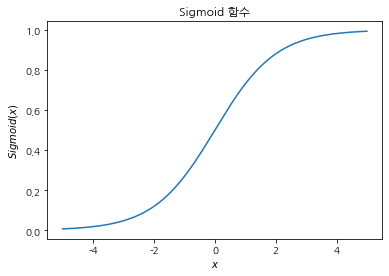

In [29]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


a = np.arange(-5, 5, 0.01)
plt.plot(a, sigmoid(a))
plt.title("Sigmoid 함수")
plt.xlabel("$x$")
plt.ylabel("$Sigmoid(x)$");

ReLU 함수

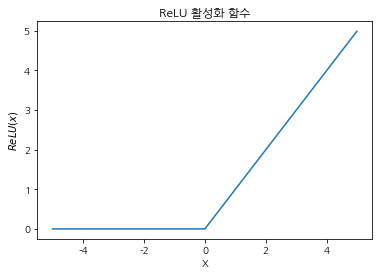

In [30]:
def relu(x):
    return np.array([el if el > 0 else 0 for el in x])

a = np.arange(-5, 5, 0.01)
plt.plot(a, relu(a))
plt.title("ReLU 활성화 함수")
plt.xlabel("X")
plt.ylabel("$ReLU(x)$");

Tanh 함수

Text(0, 0.5, '$Tanh(x)$')

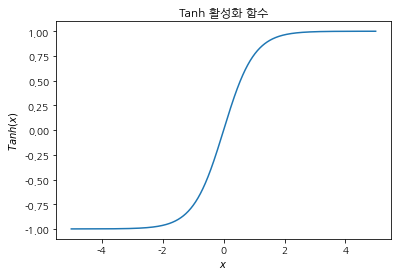

In [31]:
a = np.arange(-5, 5, 0.01)
plt.plot(a, np.tanh(a))
plt.title("Tanh 활성화 함수")
plt.xlabel("$x$")
plt.ylabel("$Tanh(x)$")

Sigmoid와 Tanh 두 함수의 기울기 변화 그래프

Text(0.5, 0, 'x')

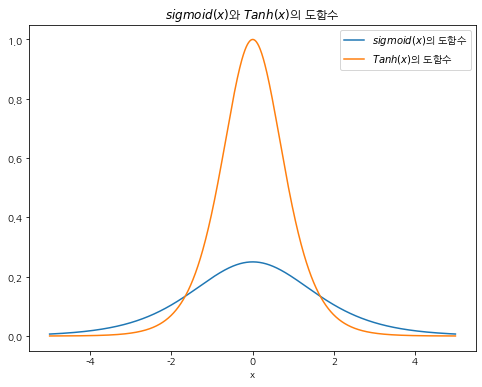

In [33]:
a = np.arange(-5, 5, 0.01)
plt.figure(figsize = (8,6))
plt.plot(a, sigmoid(a) * (1 - (sigmoid(a))))
plt.plot(a, 1 - (np.tanh(a) ** 2))
plt.legend(['$sigmoid(x)$의 도함수', 
            '$Tanh(x)$의 도함수'])
plt.title("$sigmoid(x)$와 $Tanh(x)$의 도함수")
plt.xlabel("x")

### lincoln 라이브러리 임포트

In [34]:
%load_ext autoreload
%autoreload 2

In [36]:
%cd /content/drive/MyDrive/colab/deep_learning_basic/처음_시작하는_딥러닝

/content/drive/MyDrive/colab/deep_learning_basic/처음_시작하는_딥러닝


In [63]:
import lincoln
from lincoln.layers import Dense
from lincoln.losses import SoftmaxCrossEntropy, MeanSquaredError
from lincoln.optimizers import Optimizer, SGD, SGDMomentum
from lincoln.activations import Sigmoid, Tanh, Linear, ReLU
from lincoln.network import NeuralNetwork
from lincoln.train import Trainer
from lincoln.utils import mnist
from lincoln.utils.np_utils import softmax

In [38]:
mnist.init()

Download complete.
Save complete.


In [39]:
# 데이터 로드
X_train, y_train, X_test, y_test = mnist.load()

In [40]:
num_labels = len(y_train)
num_labels

60000

#### 데이터 전처리

In [41]:
# 원 핫 인코딩
num_labels = len(y_train)
train_labels = np.zeros((num_labels, 10))
for i in range(num_labels):
  train_labels[i][y_train[i]] = 1

num_labels_test = len(y_test)
test_labels = np.zeros((num_labels_test, 10))
for i in range(num_labels_test):
  test_labels[i][y_test[i]] = 1

데이터를 평균 0, 분산 1로 정규화

In [42]:
X_train, X_test = X_train - np.mean(X_train), X_test - np.mean(X_train)

In [43]:
np.min(X_train), np.max(X_train), np.min(X_test), np.max(X_test)

(-33.318421449829934,
 221.68157855017006,
 -33.318421449829934,
 221.68157855017006)

In [44]:
X_train, X_test = X_train / np.std(X_train), X_test / np.std(X_train)

In [45]:
np.min(X_train), np.max(X_train), np.min(X_test), np.max(X_test)

(-0.424073894391566, 2.821543345689335, -0.424073894391566, 2.821543345689335)

In [46]:
 def calc_accuracy_model(model, test_set):
   return print(f'''모델 검증을 위한 정확도: {np.equal(np.argmax(model.forward(test_set, inference=True), axis=1), y_test).sum() * 100.0 / test_set.shape[0]:.2f}%''')

#### 모델

소프트맥스 교차 엔트로피 손실함수 실험 - sigmoid 활성화 함수를 사용, MeanSquaredError 손실함수 사용한 경우

In [47]:
model = NeuralNetwork(layers = [Dense(neurons = 89,
                                      activation = Tanh()),
                                Dense(neurons = 10,
                                      activation = Sigmoid())],
                      loss = MeanSquaredError(),
                      seed = 20190119)

optimizer = SGD(0.1)

trainer = Trainer(model, optimizer)
trainer.fit(X_train, train_labels, X_test, test_labels,
            epochs = 50,
            eval_every = 10,
            seed = 20190119,
            batch_size = 60)

calc_accuracy_model(model, X_test)

10에폭에서 검증 데이터에 대한 손실값: 0.611
20에폭에서 검증 데이터에 대한 손실값: 0.427
30에폭에서 검증 데이터에 대한 손실값: 0.389
40에폭에서 검증 데이터에 대한 손실값: 0.373
50에폭에서 검증 데이터에 대한 손실값: 0.365
모델 검증을 위한 정확도: 72.67%


같은 조건, normalize True 한 경우

In [50]:
model = NeuralNetwork(layers = [Dense(neurons = 89,
                                      activation = Tanh()),
                                Dense(neurons = 10,
                                      activation = Sigmoid())],
                      loss = MeanSquaredError(normalize=True),
                      seed = 20190119)

optimizer = SGD(0.1)

trainer = Trainer(model, optimizer)
trainer.fit(X_train, train_labels, X_test, test_labels,
            epochs = 50,
            eval_every = 10,
            seed = 20190119,
            batch_size = 60)

calc_accuracy_model(model, X_test)

10에폭에서 검증 데이터에 대한 손실값: 0.952

20에폭에서 손실값이 증가했다. 마지막으로 측정한 손실값은 10 에폭까지 학습된 모델에서 계산된 0.952이다.
모델 검증을 위한 정확도: 41.73%


소프트맥스 교차 엔트로피 손실함수 실험 - Linear 활성화 함수를 사용, SoftmaxCrossEntropy 손실함수 사용한 경우

In [49]:
model = NeuralNetwork(layers = [Dense(neurons = 89,
                                      activation = Tanh()),
                                Dense(neurons = 10,
                                      activation = Linear())],
                      loss = SoftmaxCrossEntropy(),
                      seed = 20190119)

optimizer = SGD(0.1)

trainer = Trainer(model, optimizer)
trainer.fit(X_train, train_labels, X_test, test_labels,
            epochs = 50,
            eval_every = 10,
            seed = 20190119,
            batch_size = 60)

calc_accuracy_model(model, X_test)

10에폭에서 검증 데이터에 대한 손실값: 0.619
20에폭에서 검증 데이터에 대한 손실값: 0.568
30에폭에서 검증 데이터에 대한 손실값: 0.548
40에폭에서 검증 데이터에 대한 손실값: 0.548
50에폭에서 검증 데이터에 대한 손실값: 0.547
모델 검증을 위한 정확도: 90.95%


ReLU 활성화 함수를 사용한 경우

In [51]:
model = NeuralNetwork(
    layers=[Dense(neurons=89, 
                  activation=ReLU()),
            Dense(neurons=10, 
                  activation=Linear())],
            loss = SoftmaxCrossEntropy(), 
seed=20190119)

trainer = Trainer(model, SGD(0.1))
trainer.fit(X_train, train_labels, X_test, test_labels,
            epochs = 50,
            eval_every = 10,
            seed=20190119,
            batch_size=60);
print()
calc_accuracy_model(model, X_test)

10에폭에서 검증 데이터에 대한 손실값: 7.474

20에폭에서 손실값이 증가했다. 마지막으로 측정한 손실값은 10 에폭까지 학습된 모델에서 계산된 7.474이다.

모델 검증을 위한 정확도: 71.34%


In [52]:
model = NeuralNetwork(
    layers=[Dense(neurons=89, 
                  activation=Tanh()),
            Dense(neurons=10, 
                  activation=Linear())],
            loss = SoftmaxCrossEntropy(), 
seed=20190119)

trainer = Trainer(model, SGD(0.1))
trainer.fit(X_train, train_labels, X_test, test_labels,
            epochs = 50,
            eval_every = 10,
            seed=20190119,
            batch_size=60);
print()

10에폭에서 검증 데이터에 대한 손실값: 0.619
20에폭에서 검증 데이터에 대한 손실값: 0.568
30에폭에서 검증 데이터에 대한 손실값: 0.548
40에폭에서 검증 데이터에 대한 손실값: 0.548
50에폭에서 검증 데이터에 대한 손실값: 0.547



## 모멘텀

#### Optimizer 클래스에 모멘텀 구현하기
파라미터 수정에 모멘텀을 적용하면 그때까지 수정했던 파라미터의 각 수정 폭을 시간이 지남에 따라 지수적으로 감쇠하는 가중치로 가중한 평균값을 파라미터 수정 폭으로 삼는다.

<br/>

따라서 수정 폭의 가중치가 감쇠되는 정도를 결정하는 모멘텀 파라미터가 추가된다. 모멘텀 파라미터의 값이 클수록 현재 속도보다 누적된 파라미터 수정 폭에 더 영향을 많이 받는다.

#### 코드
- Optimizer 클래스에 파라미터를 수정할 때마다 수정 이력 저장
- 그 후 현재 기울기와 이미 저장해둔 수정 이력을 사용하면 실제 파라미터 수정 폭 계산 가능
- 모멘텀이 물리학에서 차용한 개념인 만큼 이 수정 이력을 속력이라고 부름

<br/>

[ 속력을 최신 상태로 유지하는 방법 ]
1. 모멘텀 파라미터를 곱한다
2. 현재 기울기를 더한다.

SGDMomentum 클래스

In [59]:
class SGDMomentum(Optimizer):
  """
  확률적 경사 하강법을 적용한 Optimizer
  """
  def __init__(self,
               lr: float = 0.01,
               momentum: float = 0.9) -> None:
    super().__init__()
    self.lr = lr
    self.momentum = momentum

  def step(self):
    """
    첫 번째 반복인 경우 각 파라미터의 속력을 초기화한다.
    첫 번째 반복이 아니라면 _update_rule을 적용한다.
    """
    if self.first:
      # 첫 번째 반복에서 속력 초기화
      self.velocities = [np.zeros_like(param) for param in self.net.params()]
      self.first = False


    for (param, param_grad, velocity) in zip(self.net.params(),
                                   self.net.param_grads(),
                                   self.velocities):
      # _update_rule 메서드에 속력 전달
      self._update_rule(param = param,
                        grad = param_grad,
                        velocity = velocity)
      
  def _update_rule(self, ** kwargs) -> None:
    """
    모멘텀을 적용한 파라미터 수정 규칙
    """
    # 속력 업데이트
    kwargs['velocity'] *= self.momentum
    kwargs['velocity'] += self.lr * kwargs['grad']

    # 파라미터 수정에 속력을 포함함
    kwargs['param'] -= kwargs['velocity']

#### 모멘텀을 적용한 확률적 경사 하강법

In [60]:
model = NeuralNetwork(
    layers=[Dense(neurons=89, 
                  activation=Sigmoid()),
            Dense(neurons=10, 
                  activation=Linear())],
            loss = SoftmaxCrossEntropy(), 
seed=20190119)

optim = SGDMomentum(0.1, momentum=0.9)

trainer = Trainer(model, SGDMomentum(0.1, momentum=0.9))
trainer.fit(X_train, train_labels, X_test, test_labels,
            epochs = 50,
            eval_every = 1,
            seed=20190119,
            batch_size=60);

calc_accuracy_model(model, X_test)

1에폭에서 검증 데이터에 대한 손실값: 0.615
2에폭에서 검증 데이터에 대한 손실값: 0.489
3에폭에서 검증 데이터에 대한 손실값: 0.446

4에폭에서 손실값이 증가했다. 마지막으로 측정한 손실값은 3 에폭까지 학습된 모델에서 계산된 0.446이다.
모델 검증을 위한 정확도: 92.13%


## 학습률 감쇠

선형 감쇠

In [64]:
model = NeuralNetwork(
    layers=[Dense(neurons=89, 
                  activation=Tanh()),
            Dense(neurons=10, 
                  activation=Linear())],
            loss = SoftmaxCrossEntropy(), 
seed=20190119)

optimizer = SGDMomentum(0.15, momentum=0.9, final_lr = 0.05, decay_type='linear')

trainer = Trainer(model, optimizer)
trainer.fit(X_train, train_labels, X_test, test_labels,
            epochs = 50,
            eval_every = 10,
            seed=20190119,
            batch_size=60);

calc_accuracy_model(model, X_test)

10에폭에서 검증 데이터에 대한 손실값: 0.380
20에폭에서 검증 데이터에 대한 손실값: 0.321
30에폭에서 검증 데이터에 대한 손실값: 0.303
40에폭에서 검증 데이터에 대한 손실값: 0.295

50에폭에서 손실값이 증가했다. 마지막으로 측정한 손실값은 40 에폭까지 학습된 모델에서 계산된 0.295이다.
모델 검증을 위한 정확도: 96.06%


지수 감쇠

In [65]:
model = NeuralNetwork(
    layers=[Dense(neurons=89, 
                  activation=Tanh()),
            Dense(neurons=10, 
                  activation=Linear())],
            loss = SoftmaxCrossEntropy(), 
seed=20190119)

optimizer = SGDMomentum(0.2, 
                        momentum=0.9, 
                        final_lr = 0.05, 
                        decay_type='exponential')

trainer = Trainer(model, optimizer)
trainer.fit(X_train, train_labels, X_test, test_labels,
            epochs = 50,
            eval_every = 10,
            seed=20190119,
            batch_size=60);

calc_accuracy_model(model, X_test)

10에폭에서 검증 데이터에 대한 손실값: 0.445
20에폭에서 검증 데이터에 대한 손실값: 0.346
30에폭에서 검증 데이터에 대한 손실값: 0.306

40에폭에서 손실값이 증가했다. 마지막으로 측정한 손실값은 30 에폭까지 학습된 모델에서 계산된 0.306이다.
모델 검증을 위한 정확도: 96.05%


## 초기 가중치 설정

In [66]:
n_feat = 784
n_hidden = 256

np.random.seed(190131)

a = np.random.randn(1, n_feat)
b = np.random.randn(n_feat, n_hidden)
out = np.dot(a, b).reshape(n_hidden)

Text(0.5, 1.0, '784개 입력을 받는 은닉층의\n tanh 활성화 함수를 통과한 출력값의 분포')

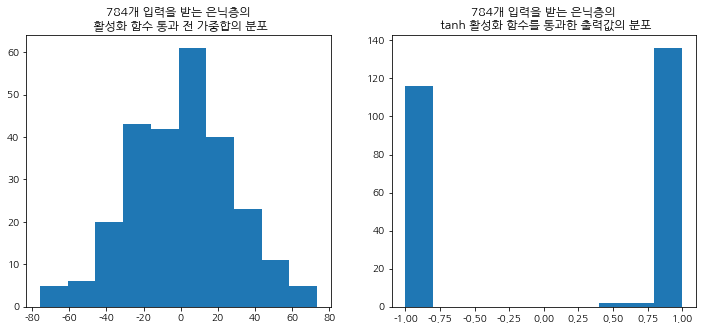

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].hist(out)
ax[0].set_title("784개 입력을 받는 은닉층의\n 활성화 함수 통과 전 가중합의 분포")
ax[1].hist(np.tanh(out))
ax[1].set_title("784개 입력을 받는 은닉층의\n tanh 활성화 함수를 통과한 출력값의 분포")

선형 감쇠

In [68]:
model = NeuralNetwork(
    layers=[Dense(neurons=89, 
                  activation=Tanh(),
                  weight_init="glorot"),        # glorot 초기화 이용
            Dense(neurons=10, 
                  activation=Linear(),
                  weight_init="glorot")],
            loss = SoftmaxCrossEntropy(), 
seed=20190119)

optimizer = SGDMomentum(0.15, momentum=0.9, final_lr = 0.05, decay_type='linear')

trainer = Trainer(model, optimizer)
trainer.fit(X_train, train_labels, X_test, test_labels,
       epochs = 50,
       eval_every = 10,
       seed=20190119,
           batch_size=60,
           early_stopping=True);

calc_accuracy_model(model, X_test)

10에폭에서 검증 데이터에 대한 손실값: 0.377
20에폭에서 검증 데이터에 대한 손실값: 0.260
30에폭에서 검증 데이터에 대한 손실값: 0.222

40에폭에서 손실값이 증가했다. 마지막으로 측정한 손실값은 30 에폭까지 학습된 모델에서 계산된 0.222이다.
모델 검증을 위한 정확도: 97.04%


지수 감쇠

In [69]:
model = NeuralNetwork(
    layers=[Dense(neurons=89, 
                  activation=Tanh(),
                  weight_init="glorot"),
            Dense(neurons=10, 
                  activation=Linear(),
                  weight_init="glorot")],
            loss = SoftmaxCrossEntropy(), 
seed=20190119)

trainer = Trainer(model, SGDMomentum(0.15, momentum=0.9, final_lr = 0.05, decay_type='exponential'))
trainer.fit(X_train, train_labels, X_test, test_labels,
       epochs = 50,
       eval_every = 10,
       seed=20190119,
           batch_size=60,
           early_stopping=True);

calc_accuracy_model(model, X_test)

10에폭에서 검증 데이터에 대한 손실값: 0.295
20에폭에서 검증 데이터에 대한 손실값: 0.223

30에폭에서 손실값이 증가했다. 마지막으로 측정한 손실값은 20 에폭까지 학습된 모델에서 계산된 0.223이다.
모델 검증을 위한 정확도: 96.62%


## 드롭아웃
드롭아웃을 적용하면 과적합을 일으키지 않으면서도 더 복잡한 모델을 학습 할 수 있다.

In [70]:
class Dropout(Operation):
  def __init__(self, 
               keep_prob: float = 0.8):
    super().__init__()
    self.keep_prob = keep_prob

  def _output(self, inference: bool) -> ndarray:
    if inference:
      return self.inputs * self.keep_prob
    else:
      self.mask = np.random.binomial(1, self.keep_prob,
                                     size = self.inputs.shape)
      return self.inputs * self.mask

  def _input_grad(self, output_grad: ndarray) -> ndarray:
    return output_grad * self.mask

#### 드롭아웃을 적용하기 위해 프레임워크 수정하기
1. Layer와 NeuralNetwork 클래스의 forward 메서드에 인자 inference를 추가하고(기본값은 False) 이 플래그의 값을 그대로 각 Operation에 전달해서 Operation 클래스가 추론 모드와 학습 모드로 나뉘어 동작할 수 있도록 한다.
2. Trainer 클래스에서 학습 중 eval_every 에폭마다 그 시점까지 학습된 모델을 테스트하는 부분에 inference 플래그를 True로 설정한다.
3. 마지막으로 Layer 클래스의 생성자 메서드에 dropout 이라는 키워드 인자를 추가한다. 수정된 Layer 클래스의 생성자 메서드는 다음과 같은 시그니처를 갖는다.
  
  def \__init__\(self, neurons: int, activation:Operation = Linear(), dropout: float = 1.0, weight_init: str = 'standard')

4. 그리고 \_setup_layer 메서드에서 다음과 같이 마지막 연산으로 dropout 연산을 추가한다.

      if self.dropout < 1.0:
          self.operations.append(Dropout(self.dropout))

#### 드롭아웃 실험

In [72]:
mnist_soft = NeuralNetwork(
    layers = [Dense(neurons = 89,
                    activation = Tanh(),
                    weight_init = 'glorot',
                    dropout = 0.8),
              Dense(neurons = 10,
                    activation = Linear(),
                    weight_init = 'glorot')],
              loss = SoftmaxCrossEntropy(),
              seed = 20190119
)

trainer = Trainer(model, SGDMomentum(0.2, momentum=0.9, final_lr = 0.05, decay_type='exponential'))
trainer.fit(X_train, train_labels, X_test, test_labels,
       epochs = 100,
       eval_every = 10,
       seed=20190119,
           batch_size=60,
           early_stopping=True);

calc_accuracy_model(model, X_test)

10에폭에서 검증 데이터에 대한 손실값: 0.441
20에폭에서 검증 데이터에 대한 손실값: 0.349
30에폭에서 검증 데이터에 대한 손실값: 0.268
40에폭에서 검증 데이터에 대한 손실값: 0.250

50에폭에서 손실값이 증가했다. 마지막으로 측정한 손실값은 40 에폭까지 학습된 모델에서 계산된 0.250이다.
모델 검증을 위한 정확도: 96.40%


은닉층의 뉴런 수를 두배로 늘리고(178), 두 번째 은닉층은 기존 첫 번째 은닉층 뉴런 수의 절반 정도(46)로 설정한다.

In [74]:
mnist_soft = NeuralNetwork(
    layers = [Dense(neurons = 178,
                    activation = Tanh(),
                    weight_init = 'glorot',
                    dropout = 0.8),
              Dense(neurons = 46,
                    activation = Tanh(),
                    weight_init = 'glorot',
                    dropout = 0.8),
              Dense(neurons = 10,
                    activation = Linear(),
                    weight_init = 'glorot')],
              loss = SoftmaxCrossEntropy(),
              seed = 20190119
)

trainer = Trainer(model, SGDMomentum(0.2, momentum=0.9, final_lr = 0.05, decay_type='exponential'))
trainer.fit(X_train, train_labels, X_test, test_labels,
       epochs = 100,
       eval_every = 10,
       seed=20190119,
           batch_size=60,
           early_stopping=True);

calc_accuracy_model(model, X_test)

10에폭에서 검증 데이터에 대한 손실값: 0.441
20에폭에서 검증 데이터에 대한 손실값: 0.349
30에폭에서 검증 데이터에 대한 손실값: 0.268
40에폭에서 검증 데이터에 대한 손실값: 0.250

50에폭에서 손실값이 증가했다. 마지막으로 측정한 손실값은 40 에폭까지 학습된 모델에서 계산된 0.250이다.
모델 검증을 위한 정확도: 96.40%
